## MDS Thesis
#### 05 Fine-tune the German ELECTRA model

<br>
<hr style="opacity: 0.5">

### Setup

In [25]:
# load libraries
import pandas as pd
import numpy as np
import os
import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import ElectraTokenizer, ElectraModel
from datasets import Dataset
from sklearn.decomposition import PCA

In [3]:
# check wd
os.getcwd()
#os.chdir("/Users/varvarailyina/hertie/mds_thesis/scripts/")

# load labels data
df_partypress = pd.read_csv("../data/in/partypress/csv/partypress.csv")

# load text data
df_texts = pd.read_csv("../data/in/partypress/csv/partypress_texts.csv")

In [4]:
# load tokenizer and model
tokenizer = ElectraTokenizer.from_pretrained('german-nlp-group/electra-base-german-uncased')
model = ElectraModel.from_pretrained('german-nlp-group/electra-base-german-uncased')

# set to evaluation mode
model.eval()

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(32767, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

<hr style="opacity: 0.5">

### Pre-process data

In [5]:
print(df_partypress.index.is_unique)
print(df_texts.index.is_unique)

True
True


In [6]:
# set merging index to be 'id'
df_partypress.set_index('id', inplace=True)
df_texts.set_index('id', inplace=True)

In [7]:
# merge datasets based on id and country_name
df = df_partypress.merge(df_texts, on=['id', 'country_name'], how='inner')

In [8]:
# check var names
print(df.columns)

Index(['country_name', 'parlgov_id', 'party', 'party_name',
       'party_name_english', 'family_name', 'date', 'month', 'month_start',
       'month_end', 'calendar_week', 'week_start', 'week_end', 'header',
       'issue_multi', 'issue_mono', 'issue', 'issue_coder2', 'position',
       'position_coder2', 'cv_sample', 'issue_ridge', 'issue_super', 'text'],
      dtype='object')


In [ ]:
# filter for germany
#df_de = df[df['country_name'] == 'germany']

# pre-process texts df
#texts = df_de['text'].dropna()
#text_df = texts.to_frame()

# convert df to dataset
#dataset = Dataset.from_pandas(text_df)

In [16]:
# filter for germany
df_de = df[df['country_name'] == 'germany']

# randomly select 100 press releases
#df_sample = df_de.sample(n=100, random_state=42)

# randomly select 4400 press releases
df_sample = df_de.sample(n=4400, random_state=42)

# pre-process texts df
texts = df_sample['text'].dropna()
text_df = texts.to_frame()

# convert df to dataset
dataset = Dataset.from_pandas(text_df)

In [17]:
df_de.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44950 entries, 18020 to 10366
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country_name        44950 non-null  object 
 1   parlgov_id          44950 non-null  float64
 2   party               44950 non-null  object 
 3   party_name          44950 non-null  object 
 4   party_name_english  44950 non-null  object 
 5   family_name         44950 non-null  object 
 6   date                44950 non-null  object 
 7   month               44950 non-null  int64  
 8   month_start         44950 non-null  object 
 9   month_end           44950 non-null  object 
 10  calendar_week       44950 non-null  int64  
 11  week_start          44950 non-null  object 
 12  week_end            44950 non-null  object 
 13  header              44950 non-null  object 
 14  issue_multi         44950 non-null  int64  
 15  issue_mono          44950 non-null  int64  
 16  issue

In [9]:
# save as .csv
df_de.to_csv("../data/in/df_de.csv", index=False)

<hr style="opacity: 0.5">

### Tokenization and embeddings

-- *Tokenize data*

In [18]:
# keep index as id
df_sample.reset_index(inplace=True)
df_sample.rename(columns={'index': 'id'}, inplace=True)

print(df_sample.columns)

Index(['id', 'country_name', 'parlgov_id', 'party', 'party_name',
       'party_name_english', 'family_name', 'date', 'month', 'month_start',
       'month_end', 'calendar_week', 'week_start', 'week_end', 'header',
       'issue_multi', 'issue_mono', 'issue', 'issue_coder2', 'position',
       'position_coder2', 'cv_sample', 'issue_ridge', 'issue_super', 'text'],
      dtype='object')


In [19]:
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors='pt')

# apply tokenization and keep 'id'
df_sample['tokenized_data'] = df_sample['text'].apply(tokenize_function)
df_sample['id'] = df_sample.index

In [20]:
# define function to tokenize data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512, return_tensors='pt')  # return_tensors='pt' for PyTorch

# run function
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 4400/4400 [00:11<00:00, 367.01 examples/s]


In [ ]:
tokenized_dataset

-- *Extract embeddings*

In [21]:
# define function to extract embeddings
def extract_embeddings(batch):
    # Ensure inputs are tensors; convert if necessary
    input_ids = torch.tensor(batch['input_ids'])
    attention_mask = torch.tensor(batch['attention_mask'])

    # forward pass, no gradient calculation
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # return embeddings; convert tensors to numpy arrays
    return {'embeddings': outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()}

# run function
embeddings = tokenized_dataset.map(extract_embeddings, batched=True)

Map: 100%|██████████| 4400/4400 [47:07<00:00,  1.56 examples/s]


In [23]:
# save into .pkl file
with open('../data/out/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [ ]:
embeddings

<hr style="opacity: 0.5">

### Emotional intensity score

-- *Reduce dimensionality*

In [26]:
# convert embeddings into a single array
all_embeddings = np.vstack([batch['embeddings'] for batch in embeddings])

In [27]:
# reduce dimensionality to 10 dimensions
pca = PCA(n_components=10)
reduced_embeddings = pca.fit_transform(all_embeddings)

In [28]:
# create scores
scores = np.linalg.norm(reduced_embeddings, axis=1)

# single score for each press release, indicating its intensity based on the PCA-reduced embeddings

-- *Top / bottom scores*

In [51]:
# create df with scores
df_scores = pd.DataFrame({
    'score': scores
}, index=df_sample.index)

# merge scores df onto original df
df_de_scored = df_sample.join(df_scores)

In [80]:
# filter out press releases with no issue
df_clean = df_de_scored[df_de_scored['issue_super'].isin([98, 99]) == False]

In [75]:
# top 10 scores
df_top10 = df_clean.sort_values(by='score', ascending=False).head(10)

# bottom 10 scores
df_bottom10 = df_clean.sort_values(by='score', ascending=True).head(10)

<hr style="opacity: 0.5">

### Visualize results

-- *Distribution of intensity scores*

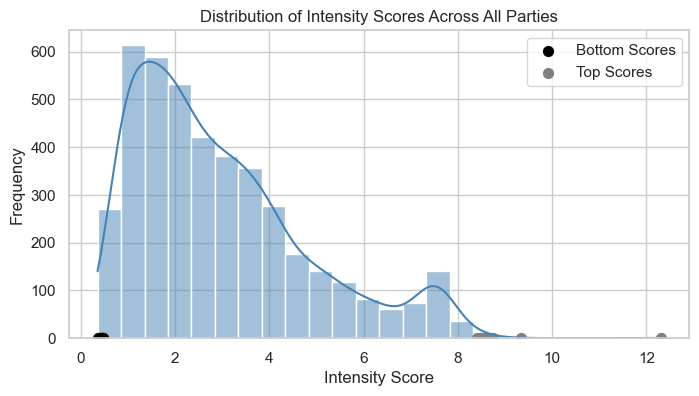

In [100]:
# set style for seaborn plots
sns.set(style="whitegrid")

# plot distribution of scores
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['score'], kde=True, color="steelblue", binwidth=0.5)
plt.scatter(df_bottom10['score'], [0]*len(df_bottom10), color='black', s=50, label='Bottom Scores')
plt.scatter(df_clean.sort_values(by='score', ascending=False).head(10)['score'], [0]*10, color='grey', s=50, label='Top Scores')
plt.title('Distribution of Intensity Scores Across All Parties')
plt.xlabel('Intensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

-- *Most / Least extreme press releases*

In [55]:
# top 10
print(df_top10['text'])

# bottom 10
print(df_bottom10['text'])

1533    Zu den Ergebnissen der neusten Arbeitszeitbefr...
4260    Zu den abschließenden Verhandlungen des Etats ...
3710    Zu der heutigen Anhörung zum Gesetzentwurf zur...
1457    Zu den heute von der Hans-Böckler-Stiftung vor...
1622    Zu Berichten, die Bundesregierung plane Kompen...
1918    Anlässlich der heutigen Öffentlichen Anhörung ...
4122    Zu der heute von der Bundesregierung beschloss...
1414    Zur ersten Lesung des Antrages der SPD-Bundest...
2445    Das Präsidium der Freien Demokratischen Partei...
664     Anlässlich der Debatte im Deutschen Bundestag ...
Name: text, dtype: object
3694    Zu den laufenden Verhandlungen bei den Vereint...
4176    Zum internationalen Tag der Tropenwälder am 14...
482     „In Deutschland gibt es laut dem Hauptgeschäft...
2612    Seit vielen Jahren ist bekannt, dass Frauen we...
621     „12.000 Menschen besuchten in nur vier Tagen d...
299     „Die anhaltend hohen Studierendenzahlen zeigen...
2730    „Die Forderungen der ‚Gruppe der Fraue

-- *Changes over time by party*

In [86]:
# make sure 'month_start' is in datetime format
df_clean = df_clean.copy()
df_clean['month_start'] = pd.to_datetime(df_clean['month_start'])

# define party colors
party_colors = {
    'CDU/CSU': '#000000',  # Black
    'SPD': '#E3000F',      # Red
    'Greens': '#46962B', # Green
    'FDP': '#FFED00',      # Yellow
    'Left': '#8C3473', # Purple
    'AfD': '#009EE0'       # Blue
}

-- *Emotional intensity scores by party per month*

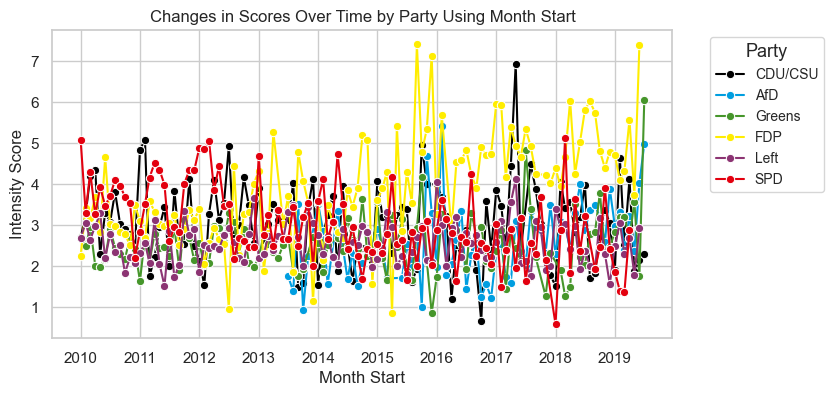

In [117]:
# line plot of scores by party over time using 'month_start'
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_clean, x='month_start', y='score', hue='party', linewidth=1.5, marker='o', palette=party_colors, errorbar=None)
plt.title('Changes in Scores Over Time by Party Using Month Start')
plt.xlabel('Month Start')
plt.ylabel('Intensity Score')
plt.legend(title='Party', title_fontsize='13', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

-- *Emotional intensity scores by party for every 2 months*

/var/folders/89/wy_4fk_j4wsfym9x7s_1s5jc0000gn/T/ipykernel_70134/297426344.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = df_clean.groupby(['party', pd.Grouper(key='month_start', freq='2M')])[numeric_cols].mean()


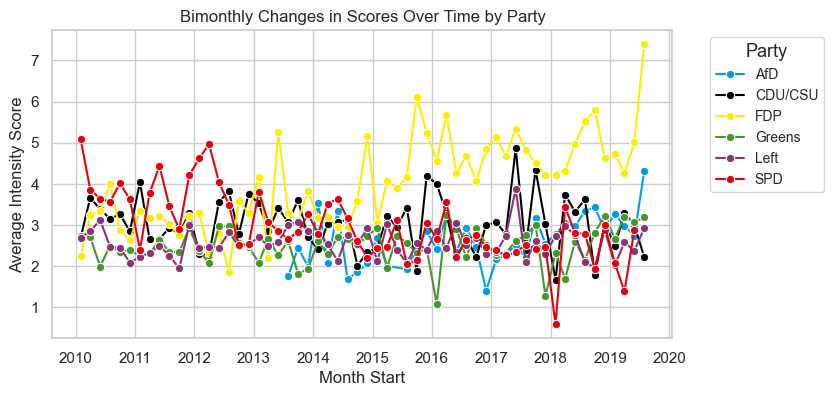

In [120]:
# only process numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# calculate mean for each group (by party + every 2 months)
grouped = df_clean.groupby(['party', pd.Grouper(key='month_start', freq='2M')])[numeric_cols].mean()

# reset the index (to make 'month_start' and 'party' columns again)
grouped.reset_index(inplace=True)

# line plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=grouped, x='month_start', y='score', hue='party', linewidth=1.5, marker='o', palette=party_colors)

plt.title('Bimonthly Changes in Scores Over Time by Party')
plt.xlabel('Month Start')
plt.ylabel('Average Intensity Score')
plt.legend(title='Party', title_fontsize='13', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

-- *Emotional intensity scores by party for every 3 months*

/var/folders/89/wy_4fk_j4wsfym9x7s_1s5jc0000gn/T/ipykernel_70134/3168502975.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  quarterly_scores = df_clean.groupby(['party', pd.Grouper(key='month_start', freq='3M')])[numeric_cols].mean()


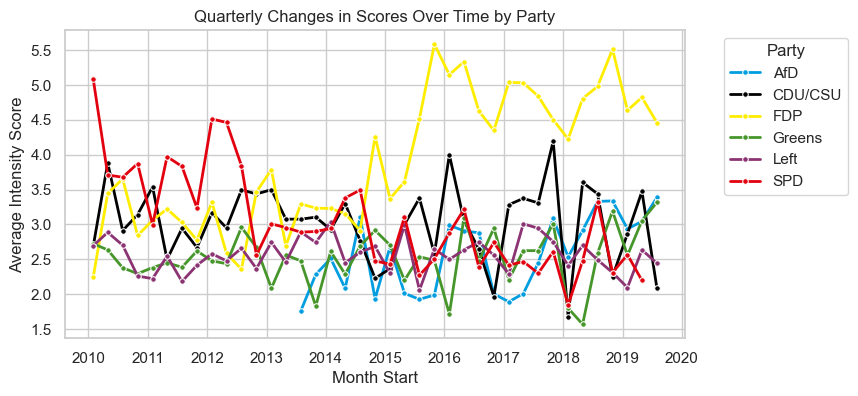

In [122]:
# only process numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# calculate mean for each group (by party + every 3 months)
quarterly_scores = df_clean.groupby(['party', pd.Grouper(key='month_start', freq='3M')])[numeric_cols].mean()

# reset the index (to make 'month_start' and 'party' columns again)
quarterly_scores.reset_index(inplace=True)

# line plot
plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(data=quarterly_scores, x='month_start', y='score', hue='party', style='party', palette=party_colors, linewidth=2, marker='o', dashes=False)

# set marker size within lines
for line in lineplot.get_lines():
    line.set_markersize(4)  # marker size

plt.title('Quarterly Changes in Scores Over Time by Party')
plt.xlabel('Month Start')
plt.ylabel('Average Intensity Score')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

-- *Emotional intensity scores by party for every 6 months*

/var/folders/89/wy_4fk_j4wsfym9x7s_1s5jc0000gn/T/ipykernel_70134/2230733812.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  semiannual_scores = df_clean.groupby(['party', pd.Grouper(key='month_start', freq='6M')])[numeric_cols].mean()


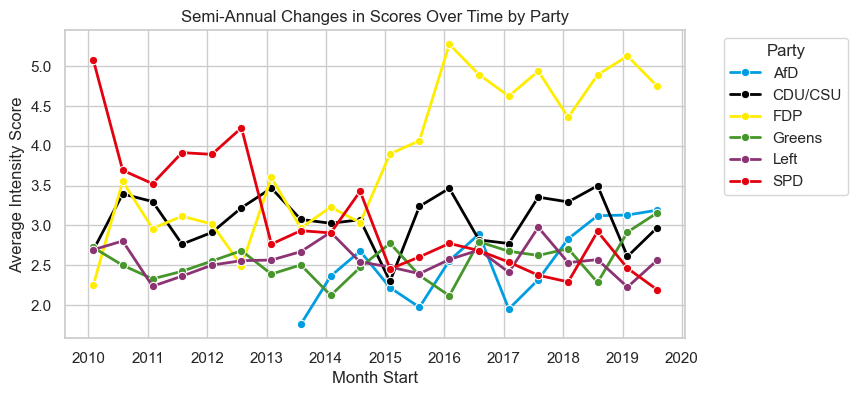

In [123]:
# only process numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# calculate mean for each group (by party + for every 6 months)
semiannual_scores = df_clean.groupby(['party', pd.Grouper(key='month_start', freq='6M')])[numeric_cols].mean()

# reset the index (to make 'month_start' and 'party' columns again)
semiannual_scores.reset_index(inplace=True)

# line plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=semiannual_scores, x='month_start', y='score', hue='party', linewidth=2, marker='o', palette=party_colors)
plt.title('Semi-Annual Changes in Scores Over Time by Party')
plt.xlabel('Month Start')
plt.ylabel('Average Intensity Score')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

-- *Summary statistics by party*

/var/folders/89/wy_4fk_j4wsfym9x7s_1s5jc0000gn/T/ipykernel_70134/713699262.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='party', y='score', palette=party_colors)


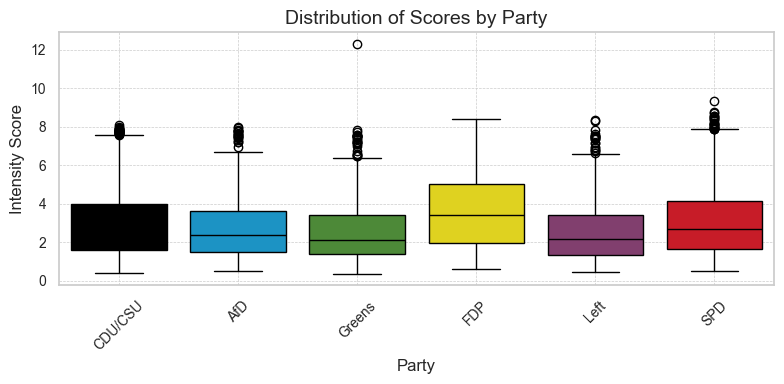

In [124]:
# box plot for scores by party
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_clean, x='party', y='score', palette=party_colors)
plt.title('Distribution of Scores by Party', fontsize=14)
plt.xlabel('Party', fontsize=12)
plt.ylabel('Intensity Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)  # Adding a light grid for better readability
plt.tight_layout()  # Adjust layout to avoid cutting off label texts
plt.show()

In [125]:
# score averages by party
average_scores_by_party = df_de_scored.groupby('party')['score'].mean()
print(average_scores_by_party)

party
AfD        2.885723
CDU/CSU    3.116016
FDP        3.860562
Greens     2.563521
Left       2.552306
SPD        3.214118
Name: score, dtype: float64
